<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [445]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [446]:
# import Housing.csv from the Drive
file_path = '/content/drive/My Drive/ML/HW2/Housing.csv'
housing = pd.read_csv(file_path)

In [447]:
# Checking Null. If there are no NULL values in the dataset, it is clean.
housing.isnull().sum()*100/housing.shape[0]

,0
price,0.0
area,0.0
bedrooms,0.0
bathrooms,0.0
stories,0.0
mainroad,0.0
guestroom,0.0
basement,0.0
hotwaterheating,0.0
airconditioning,0.0


In [448]:
# List of variables to map
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})
# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)


In [449]:
# feature set from the data
num_vars = ['area','bedrooms','bathrooms','stories','mainroad','guestroom',
        'basement','hotwaterheating','airconditioning','parking','prefarea']


In [450]:
#80/20 split
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(housing, train_size=0.8, test_size=0.2, random_state=100)

In [451]:
y_train = df_train.pop('price').astype(float).values
y_val   = df_test.pop('price').astype(float).values

In [452]:
#Standardization using built-in function
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(df_train[num_vars]), columns=num_vars)
X_val   = pd.DataFrame(scaler.transform(df_test[num_vars]),     columns=num_vars)

In [453]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

def r2_mse(y_true, y_pred):
    return r2_score(y_true, y_pred), mean_squared_error(y_true, y_pred)

base_pipe = Pipeline([("svr", SVR())])

C_grid      = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
gamma_grid  = ["scale", "auto", 0.1, 0.01, 0.001]   # for rbf/sigmoid SVR
degree_grid = [2, 3, 4]                             # for poly SVR

results = []
best_model = {}


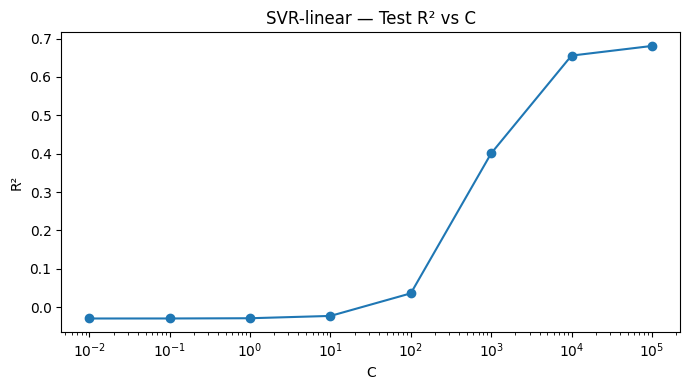

In [454]:
# SVR-linear
r2_curve = []
best = {"r2": -np.inf}
for C in C_grid:
    mdl = base_pipe.set_params(svr__kernel="linear", svr__C=C).fit(X_train, y_train)
    r2, mse = r2_mse(y_val, mdl.predict(X_val))
    r2_curve.append(r2)
    if r2 > best["r2"]:
        best = {"r2": r2, "mse": mse, "C": C, "model": mdl}
plt.figure(figsize=(7,4))
plt.semilogx(C_grid, r2_curve, marker='o'); plt.title("SVR-linear — Test R² vs C")
plt.xlabel("C"); plt.ylabel("R²"); plt.tight_layout(); plt.show()
results.append({"Model":"SVR-linear","Best C":best["C"],"R2":best["r2"],"MSE":best["mse"]})
best_model["linear"] = best["model"]

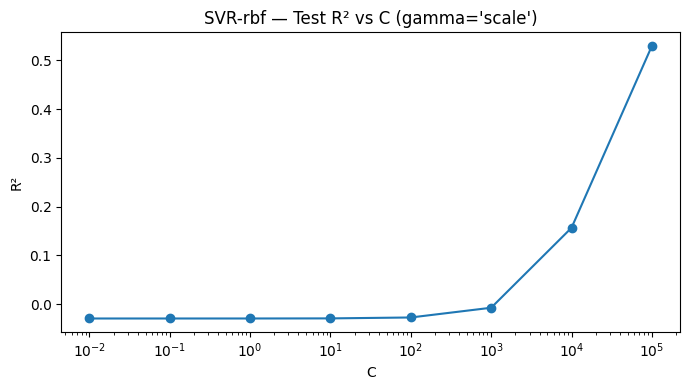

In [455]:
# SVR-rbf
r2_curve = []
best = {"r2": -np.inf}
for C in C_grid:
    # draw a single curve with gamma='scale'
    mdl_plot = base_pipe.set_params(svr__kernel="rbf", svr__C=C, svr__gamma="scale").fit(X_train, y_train)
    r2_plot, _ = r2_mse(y_val, mdl_plot.predict(X_val))
    r2_curve.append(r2_plot)
    # full sweep over gamma for the selection
    for g in gamma_grid:
        mdl = base_pipe.set_params(svr__kernel="rbf", svr__C=C, svr__gamma=g).fit(X_train, y_train)
        r2, mse = r2_mse(y_val, mdl.predict(X_val))
        if r2 > best["r2"]:
            best = {"r2": r2, "mse": mse, "C": C, "gamma": g, "model": mdl}
plt.figure(figsize=(7,4))
plt.semilogx(C_grid, r2_curve, marker='o'); plt.title("SVR-rbf — Test R² vs C (gamma='scale')")
plt.xlabel("C"); plt.ylabel("R²"); plt.tight_layout(); plt.show()
results.append({"Model":"SVR-rbf","Best C":best["C"],"Best gamma":best.get("gamma"),
                "R2":best["r2"],"MSE":best["mse"]})
best_model["rbf"] = best["model"]

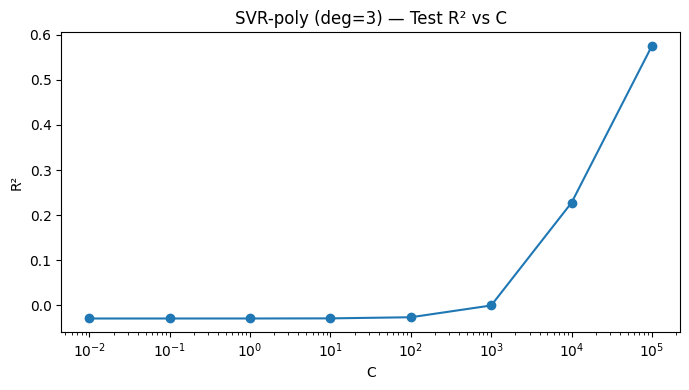

In [456]:
# SVR-poly
r2_curve = []
best = {"r2": -np.inf}
for C in C_grid:
    mdl_plot = base_pipe.set_params(svr__kernel="poly", svr__C=C, svr__degree=3,
                                    svr__gamma="scale", svr__coef0=0.0).fit(X_train, y_train)
    r2_plot, _ = r2_mse(y_val, mdl_plot.predict(X_val))
    r2_curve.append(r2_plot)
    for d in degree_grid:
        mdl = base_pipe.set_params(svr__kernel="poly", svr__C=C, svr__degree=d,
                                   svr__gamma="scale", svr__coef0=0.0).fit(X_train, y_train)
        r2, mse = r2_mse(y_val, mdl.predict(X_val))
        if r2 > best["r2"]:
            best = {"r2": r2, "mse": mse, "C": C, "degree": d, "model": mdl}
plt.figure(figsize=(7,4))
plt.semilogx(C_grid, r2_curve, marker='o'); plt.title("SVR-poly (deg=3) — Test R² vs C")
plt.xlabel("C"); plt.ylabel("R²"); plt.tight_layout(); plt.show()
results.append({"Model":"SVR-poly","Best C":best["C"],"Best degree":best.get("degree"),
                "R2":best["r2"],"MSE":best["mse"]})
best_model["poly"] = best["model"]

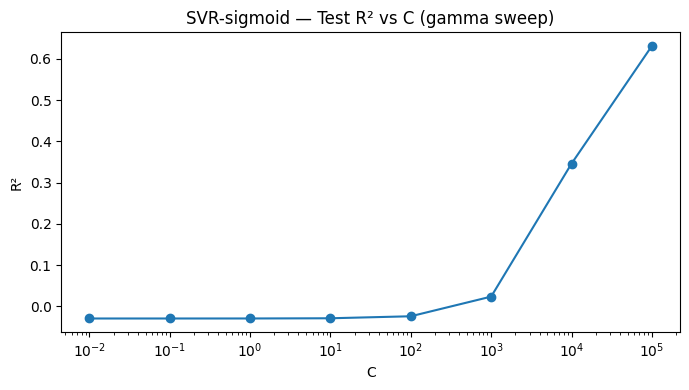

In [457]:
# SVR-sigmoid
r2_curve = []
best = {"r2": -np.inf}
for C in C_grid:
    mdl_plot = base_pipe.set_params(svr__kernel="sigmoid", svr__C=C, svr__gamma="scale",
                                    svr__coef0=0.0).fit(X_train, y_train)
    r2_plot, _ = r2_mse(y_val, mdl_plot.predict(X_val))
    r2_curve.append(r2_plot)
    for g in gamma_grid:
        mdl = base_pipe.set_params(svr__kernel="sigmoid", svr__C=C, svr__gamma=g,
                                   svr__coef0=0.0).fit(X_train, y_train)
        r2, mse = r2_mse(y_val, mdl.predict(X_val))
        if r2 > best["r2"]:
            best = {"r2": r2, "mse": mse, "C": C, "gamma": g, "model": mdl}
plt.figure(figsize=(7,4))
plt.semilogx(C_grid, r2_curve, marker='o'); plt.title("SVR-sigmoid — Test R² vs C (gamma sweep)")
plt.xlabel("C"); plt.ylabel("R²"); plt.tight_layout(); plt.show()
results.append({"Model":"SVR-sigmoid","Best C":best["C"],"Best gamma":best.get("gamma"),
                "R2":best["r2"],"MSE":best["mse"]})
best_model["sigmoid"] = best["model"]

In [458]:
# HW2: linear regression with L2 regularization (Ridge)
best_ridge = {"r2": -np.inf}
for alpha in [0.01, 0.1, 1, 10, 100, 1000]:
    # fit on standardized inputs, like SVR
    from sklearn.linear_model import Ridge
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=alpha))]).fit(
        df_train[num_vars], y_train
    )
    r2, mse = r2_mse(y_val, ridge.predict(df_test[num_vars]))
    if r2 > best_ridge["r2"]:
        best_ridge = {"r2": r2, "mse": mse, "alpha": alpha}
results.append({"Model":f"Ridge (α={best_ridge['alpha']})","Best C":"—","R2":best_ridge["r2"],"MSE":best_ridge["mse"]})


In [459]:
# Summary table (accuracies + MSE)
summary = pd.DataFrame(results)
print(summary.round(4).to_string(index=False))

        Model Best C     R2          MSE Best gamma  Best degree
   SVR-linear 100000 0.6807 1.127000e+12        NaN          NaN
      SVR-rbf 100000 0.5292 1.661512e+12      scale          NaN
     SVR-poly 100000 0.5753 1.498869e+12        NaN          3.0
  SVR-sigmoid 100000 0.6314 1.300848e+12      scale          NaN
Ridge (α=100)      — 0.6760 1.143622e+12        NaN          NaN


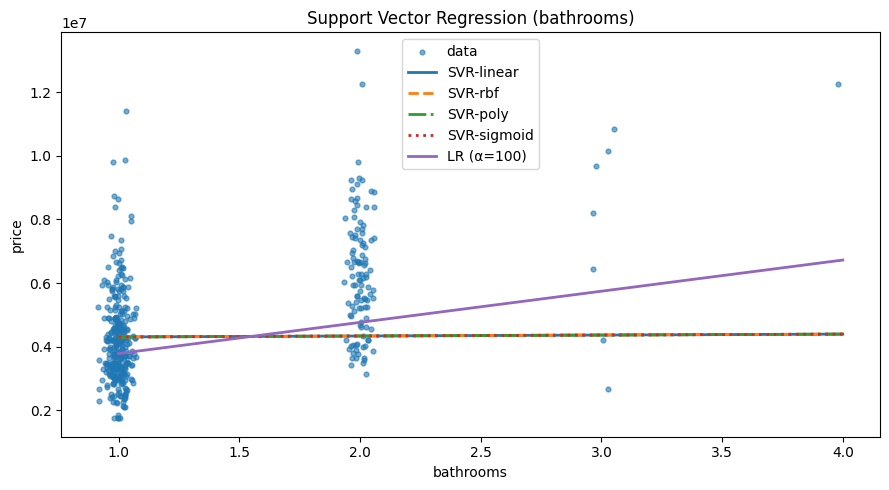

In [460]:
# Target vs data plot on a chosen feature
slice_feature = "bathrooms"

x_min, x_max = df_train[slice_feature].min(), df_train[slice_feature].max()
x_grid = np.linspace(x_min, x_max, 120)

X_fix = df_train[num_vars].median()

def predict_over_feature(model, feat, needs_scaled: bool):
    Xg = pd.DataFrame({c: np.full_like(x_grid, X_fix[c], dtype=float) for c in num_vars})
    Xg[feat] = x_grid
    if needs_scaled:
      Xg = pd.DataFrame(scaler.transform(Xg), columns=num_vars)
    return model.predict(Xg)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
ridge_best = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=best_ridge["alpha"]))]).fit(
    df_train[num_vars], y_train
)

# Curves from the best models found earlier
y_lin_curve   = predict_over_feature(best_model["linear"],  slice_feature, True)
y_rbf_curve   = predict_over_feature(best_model["rbf"],     slice_feature, True)
y_poly_curve  = predict_over_feature(best_model["poly"],    slice_feature, True)
y_sig_curve   = predict_over_feature(best_model["sigmoid"], slice_feature, True)
y_ridge_curve = predict_over_feature(ridge_best,            slice_feature, False)

plt.figure(figsize=(9,5))

jitter = 0.03 if slice_feature in ["bedrooms","bathrooms","stories","parking",
                                   "mainroad","guestroom","basement",
                                   "hotwaterheating","airconditioning","prefarea"] else 0.0
plt.scatter(df_train[slice_feature] + jitter*np.random.randn(len(df_train)),
            y_train, s=12, alpha=0.6, label="data")

plt.plot(x_grid, y_lin_curve,   lw=2, ls='-',   label="SVR-linear")
plt.plot(x_grid, y_rbf_curve,   lw=2, ls='--',  label="SVR-rbf")
plt.plot(x_grid, y_poly_curve,  lw=2, ls='-.',  label="SVR-poly")
plt.plot(x_grid, y_sig_curve,   lw=2, ls=':',   label="SVR-sigmoid")
plt.plot(x_grid, y_ridge_curve, lw=2, ls='-',   label=f"LR (α={best_ridge['alpha']})")

plt.xlabel(slice_feature); plt.ylabel("price")
plt.title(f"Support Vector Regression ({slice_feature})")
plt.legend(); plt.tight_layout(); plt.show()
